# Analysis of Atomic Beam Oven Thermal Testing (Internal Oven Only)

# TYPE T SETTING USED FOR TYPE K THERMOCOUPLE --> DATA MUST BE CONVERTED

In [1]:
#Display matplot lib plots in the notebook
%matplotlib inline 

#Import all modules needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit as fit
from scipy.optimize import curve_fit

#Set graph style and size
sns.set(style ="whitegrid")

## Read data into dataframes:

Start reading in the 410 mA results to check what the data looks like.

In [2]:
result410mA = pd.read_csv("/home/manish/Documents/Lab/Data/2018/Atomic Beam Oven Thermal Analysis/InternalOven/ThermocoupleTesting - 410mA&14.4V.csv", skiprows = [0, 1, 2])

In [3]:
result410mA.head()

time (min)  T (deg C)
0           0      119.7
1           5      128.8
2          10      132.8
3          15      136.4
4          20      139.4

In [4]:
result410mA.columns = ["time", "temp"]

In [5]:
result410mA.head()

time   temp
0     0  119.7
1     5  128.8
2    10  132.8
3    15  136.4
4    20  139.4

In [6]:
result410mA.dtypes

time      int64
temp    float64
dtype: object

In [7]:
result410mA["temp_error"] = 0.1
result410mA.head()

time   temp  temp_error
0     0  119.7         0.1
1     5  128.8         0.1
2    10  132.8         0.1
3    15  136.4         0.1
4    20  139.4         0.1

Now read in the 510 mA, 800 mA, and 1030 mA results:

In [8]:
result510mA = pd.read_csv("/home/manish/Documents/Lab/Data/2018/Atomic Beam Oven Thermal Analysis/InternalOven/ThermocoupleTesting - 510mA&17.8V.csv", skiprows = [0,1,2])
result800mA = pd.read_csv("/home/manish/Documents/Lab/Data/2018/Atomic Beam Oven Thermal Analysis/InternalOven/ThermocoupleTesting - 800mA&27.3V.csv")
result1030mA = pd.read_csv("/home/manish/Documents/Lab/Data/2018/Atomic Beam Oven Thermal Analysis/InternalOven/ThermocoupleTesting - 1030mA&35.4V.csv")

Rename the columns

In [9]:
result510mA.columns = ["time", "temp"]
result800mA.columns = ["time", "temp"]
result1030mA.columns = ["time", "temp"]
result1030mA.head()

time   temp
0     0   26.1
1     5   95.5
2    10  155.8
3    15  199.1
4    20  229.6

Add error on the temperature to 510 mA, 800 mA, and 1030 mA results. We can use a function with a variable number of arguments (an `*args` function) to make the code concise.

In [10]:
def AddTempErr(*args):
    for df in args:
        df["temp_error"]=0.1
    return

AddTempErr(result510mA, result800mA, result1030mA)
result1030mA.head()

time   temp  temp_error
0     0   26.1         0.1
1     5   95.5         0.1
2    10  155.8         0.1
3    15  199.1         0.1
4    20  229.6         0.1

## Plotting the data

Define a `PlotData()` function which calls in a variable number of non-keyworded (`*args`) and keyworded (`**kwargs`) argumenmts to plot data in one graph for many dataframes.

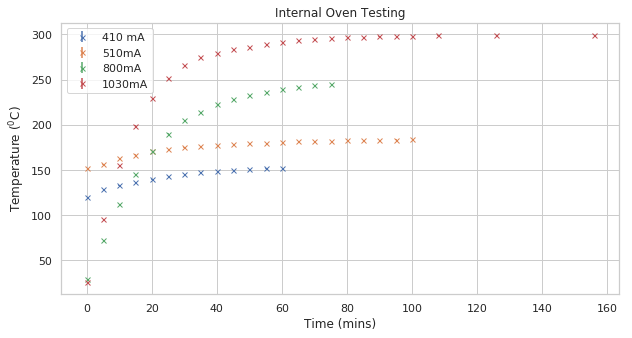

In [11]:
def PlotData(*args, **kwargs):
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    ax = fig.add_subplot(1,1,1)
    for df, key in zip(args, kwargs): #zip takes the series of args and kwargs and makes it into one list of tuples
        ax.errorbar(df["time"], df["temp"], df["temp_error"], label = kwargs[key], fmt = 'x', markersize = 5)
    ax.set_title("Internal Oven Testing")
    ax.set_ylabel("Temperature ($^0$C)")
    ax.set_xlabel("Time (mins)")
    ax.legend()
    return fig

fig_internal_oven = PlotData(result410mA, result510mA, result800mA, result1030mA, label1 = "410 mA", label2 = "510mA", label3 = "800mA", label4 = "1030mA")

## Modelling the data
We can express the difference in temperature between the hotter heating element $T_H$ and the temperature of the oven $T_C$ as 

$\Delta T(t) = T_H(t) - T_C(t)$

where these are both functions of time $t$. By using Fourier's Law

$ \dot{Q} = - \kappa \nabla T$

we can derive an expression for $\Delta T$:

$\Delta T(t)= Ae^{-kt}$

where $A$ and $k$ are constants. Using the expression for $\Delta T$ as above and assuming that $T_H(t)$ at large times is a constant $T_H$ we get the functional form of the oven temperature:

$T_C(t) = T_H - Ae^{-kt}$.

By using the initial condition that $T_c = T_0$ at $t=0$,

$T_C(t=0) = T_0$,

we can find an expression for $A$ and substitute this back into the equation so that now our model is

$T_C(t) = T_H - (T_H-T_0)e^{-kt}$.

We can use this model to perform a fit using the `lmfit` package.

**The issue with the model is that it is only valid at large times** - we have to fit the data when $t$ is large enough.

First, we define our model:

In [12]:
def TempTimeModel(t, T_H, T_0, k):
    return T_H - (T_H - T_0)*np.exp(-k*t)

Now we have to get the initial parameters of our model. Let's define a test function and try to input parameters until we get a reasonable fit.

Do this with the 410mA data

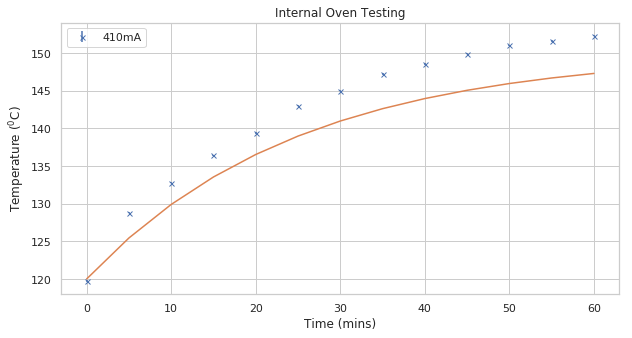

In [13]:
test_fig = PlotData(result410mA, label = "410mA")
def test_func(t,k):
    return  150 - (150-120)*np.exp(-k*t)
k = 0.01
test_fig.get_axes()[0].plot(result410mA["time"], test_func(result410mA["time"], k = 0.04))

Then we try to fit for 410mA. Let's try for 5 minutes and onwards:

In [14]:
Model410mA = fit.Model(TempTimeModel)  #Create Model object
Model410mA.param_names  #Display the parameter names
Params410mA = Model410mA.make_params(T_H = 150, T_0 = 120, k=0.03)  #Initialise parameters to a starting value
temp_range410mA = result410mA.iloc[1:,1]  #Don't want to fit the whole range, only 5 minutes and onwards
time_range410mA = result410mA.iloc[1:,0]
sigma_temp_range410mA = result410mA.iloc[1:,2]
#sigma_temp_range410mA.head()
fit410mA = Model410mA.fit(temp_range410mA, Params410mA, t=time_range410mA, weights=sigma_temp_range410mA)  #Perform the fit
print(fit410mA.fit_report())

[[Model]]
    Model(TempTimeModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 12
    # variables        = 3
    chi-square         = 0.01090710
    reduced chi-square = 0.00121190
    Akaike info crit   = -78.0389714
    Bayesian info crit = -76.5842514
[[Variables]]
    T_H:  156.762047 +/- 0.70029878 (0.45%) (init = 150)
    T_0:  123.039691 +/- 0.50749188 (0.41%) (init = 120)
    k:    0.03485626 +/- 0.00193817 (5.56%) (init = 0.03)
[[Correlations]] (unreported correlations are < 0.100)
    C(T_H, k)   = -0.958
    C(T_0, k)   = -0.813
    C(T_H, T_0) =  0.672



Let's see how well `scipy.optimize.curve_fit()` does:

popt =  [1.56762047e+02 1.23039691e+02 3.48562559e-02]
pcov =  [[ 4.90418575e-01  2.38731031e-01 -1.30067638e-03]
 [ 2.38731031e-01  2.57548034e-01 -7.99361310e-04]
 [-1.30067638e-03 -7.99361310e-04  3.75650973e-06]]


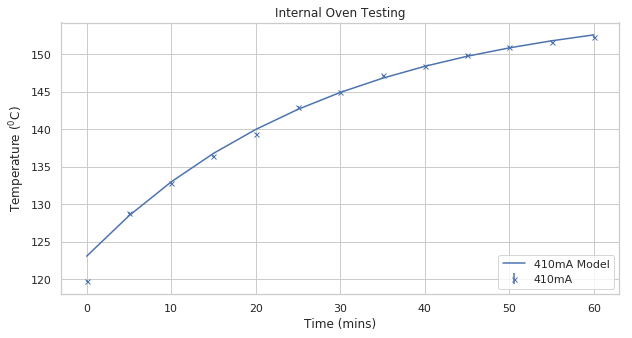

In [15]:
popt, pcov = curve_fit(TempTimeModel, xdata = time_range410mA, ydata=temp_range410mA, sigma=sigma_temp_range410mA, p0 = [150, 120, 0.03])
print("popt = ", popt)
print("pcov = ",  pcov)
fig_410mA = PlotData(result410mA, label = "410mA")
fig_410mA.get_axes()[0].plot(result410mA["time"], TempTimeModel(result410mA["time"], T_H = popt[0], T_0 = popt[1], k = popt[2]), label = "410mA Model", color ="b")
fig_410mA.get_axes()[0].legend(loc = "lower right")

Let's see how to retrieve the `lmfit` fit results: 

In [19]:
print(fit410mA.best_values)  #The best values are a dictionary of results
print(fit410mA.best_values["T_H"])

{'T_H': 156.76204668981316, 'T_0': 123.03969145841188, 'k': 0.03485625596745322}
156.76204668981316
